`jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0`

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 7.7 MB/s eta 0:00:00


In [ ]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 24px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

**Import Libs**

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm
import torchmetrics as tm

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tqdm, tm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
pandas --> 1.5.3
cv2 --> 4.8.0
PIL --> 9.4.0
sklearn --> 1.2.2
torch --> 2.0.1+cu118
torchvision --> 0.15.2+cu118
tqdm --> 4.66.1
torchmetrics --> 1.1.1


#  **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

##  Copy & Unzip the Dataset

In [ ]:
!tar -xzf '/content/drive/MyDrive/deep-catalyst/project_0-age_estimation/data/UTKFace.tar.gz' -C '/content/'

* x: This flag stands for "extract". It tells the tar command to extract the files from the archive.

* v: This flag stands for "verbose". It displays the list of files being extracted in the terminal.

* z: This flag indicates that the archive file is compressed using gzip.

* f: This flag indicates that the following argument is the name of the archive file.

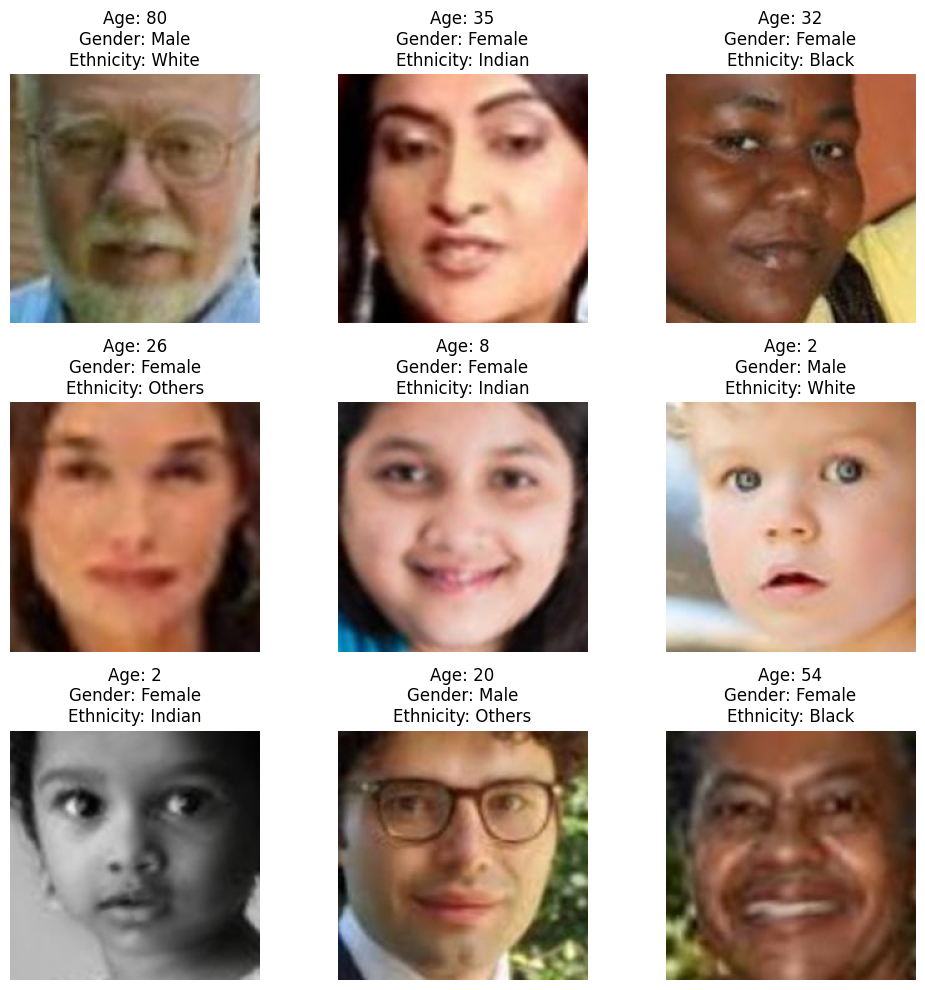

In [ ]:
# Replace with the actual path to your UTK dataset images folder
dataset_folder = '/content/UTKFace/'

def show_random_samples(num_samples=9):
    image_files = os.listdir(dataset_folder)
    selected_image_files = random.sample(image_files, num_samples)

    plt.figure(figsize=(10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path = os.path.join(dataset_folder, image_file)
        age, gender, ethnicity = image_file.split('_')[:3]

        image = Image.open(image_path)

        gender = 'Male' if int(gender) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display random samples
show_random_samples()


###  Create a csv file which contains labels

🔰 During this session, your mission is to:
   

*   create the following DataFrame
*   and save it as a CSV file named 'utkface_dataset.csv'


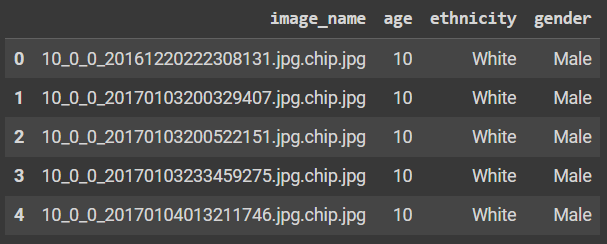

In [ ]:
dataset_dir = '/content/UTKFace'
ll = os.listdir(dataset_dir)

In [ ]:
ll[0].split('_')

['68', '0', '0', '20170117172347609.jpg.chip.jpg']

In [ ]:
# Path to the UTKFace dataset directory
dataset_dir = '/content/UTKFace'

# Initialize lists to store data
image_names = []
ages = []
ethnicities = []
genders = []

# Iterate through files in the directory
for filename in os.listdir(dataset_dir):
    if filename.endswith('.jpg'):
        parts = filename.split('_')
        # Format: [age]_[gender]_[ethnicity]_[other_info].jpg
        if len(parts) < 4:
          print(filename)
          continue
        #
        age = int(parts[0])
        gender = 'Male' if int(parts[1]) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(parts[2])]
        #
        if age > 80:
          continue

        image_names.append(filename)
        ages.append(age)
        ethnicities.append(ethnicity)
        genders.append(gender)

# Create a DataFrame from the lists
data = {
    'image_name': image_names,
    'age': ages,
    'ethnicity': ethnicities,
    'gender': genders
}
df = pd.DataFrame(data)

# Save DataFrame to CSV
csv_filename = '/content/utkface_dataset.csv'
df.to_csv(csv_filename, index=False)

print(f"CSV file '{csv_filename}' created successfully.")

39_1_20170116174525125.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg
61_1_20170109150557335.jpg.chip.jpg
CSV file '/content/utkface_dataset.csv' created successfully.


In [ ]:
df.head()

,image_name,age,ethnicity,gender
0,68_0_0_20170117172347609.jpg.chip.jpg,68,White,Male
1,1_1_1_20170109194626438.jpg.chip.jpg,1,Black,Female
2,38_1_1_20170114030101602.jpg.chip.jpg,38,Black,Female
3,28_0_1_20170113151400128.jpg.chip.jpg,28,Black,Male
4,37_1_0_20170103183009635.jpg.chip.jpg,37,White,Female


### 🟡 Plot histogram for age

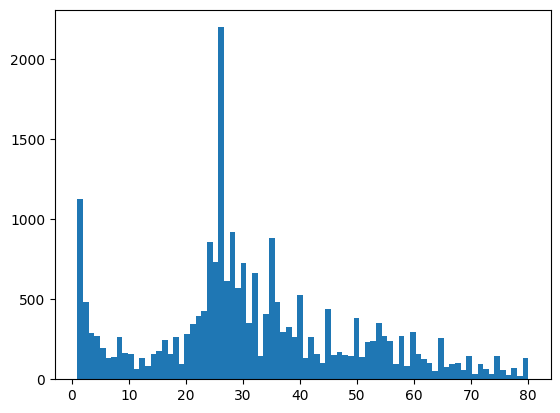

In [ ]:
plt.hist(df.age, bins=len(df.age.unique()));

In [ ]:
df.age.describe()

count    23165.000000
mean        32.024218
std         18.227409
min          1.000000
25%         23.000000
50%         29.000000
75%         42.000000
max         80.000000
Name: age, dtype: float64

In [ ]:
df.age.value_counts()

26    2197
1     1123
28     918
35     880
24     859
      ... 
64      50
71      33
74      32
77      28
79      23
Name: age, Length: 80, dtype: int64

#### 🛑 **Tip:** You can use Plotly or Seaborn libraries to create visually appealing plots!

### 🟡 Plot histogram for gender

(array([1833., 1642.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

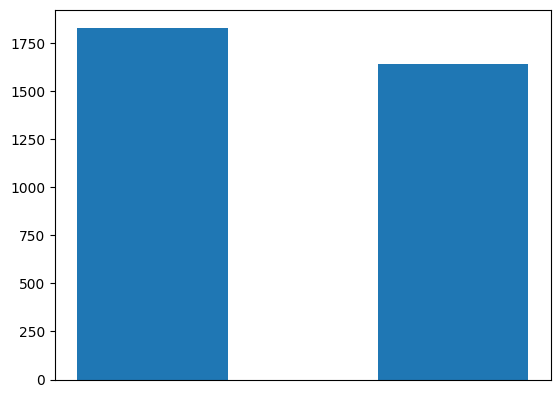

In [ ]:
plt.hist(df.gender, bins=2, rwidth=0.5)

In [ ]:
df.gender.value_counts()

Male      12208
Female    10957
Name: gender, dtype: int64

### 🟡 Plot histogram for ethnicity

(array([3952., 9698., 3348., 4478., 1689.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

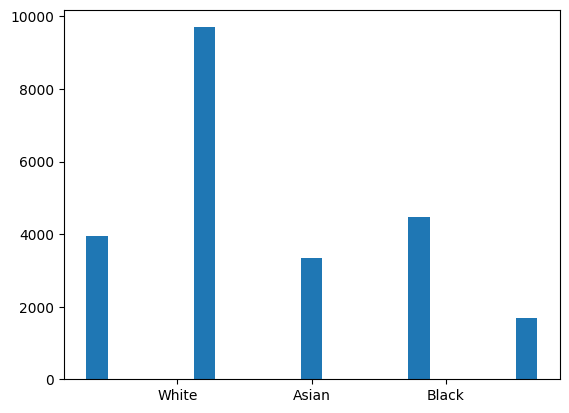

In [ ]:
plt.hist(df.ethnicity, bins=len(df.ethnicity.unique()), rwidth=0.2)

In [ ]:
df.ethnicity.value_counts()

White     9698
Black     4478
Indian    3952
Asian     3348
Others    1689
Name: ethnicity, dtype: int64

### 🟡 Calculate the cross-tabulation of gender and ethnicity using the pandas.crosstab() function.

In [ ]:
pd.crosstab(index=df.gender, columns=df.ethnicity)

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1810,2182,1698,930,4337
Male,1538,2296,2254,759,5361


### 🟡 Create violin plots and box plots for age, separately for men and women.

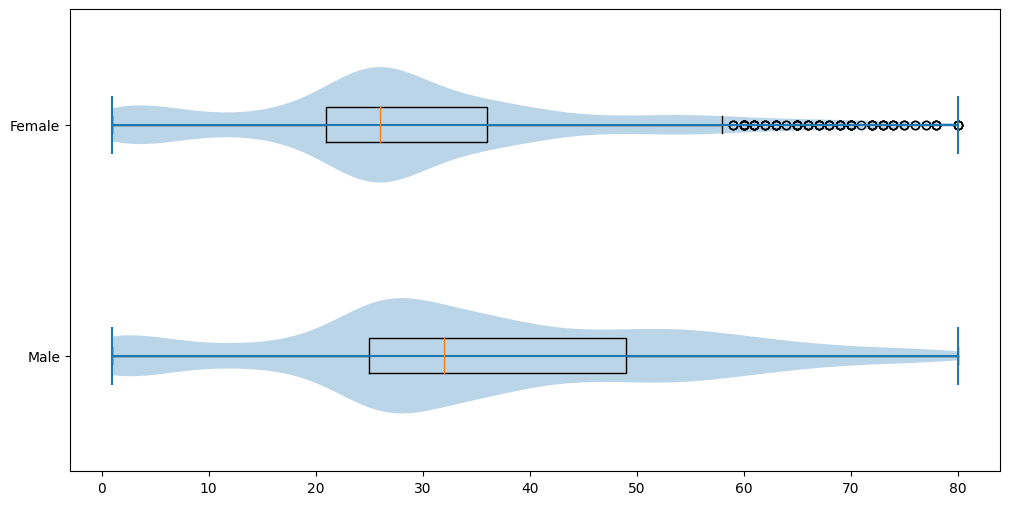

In [ ]:
plt.figure(figsize=(12, 6))
plt.boxplot([df.age[df.gender == cat] for cat in df.gender.unique()], vert=False, labels=df.gender.unique())
plt.violinplot([df.age[df.gender == cat] for cat in df.gender.unique()], vert=False);

### 🟡 Create violin plots and box plots for age, separately for each ethnicity.

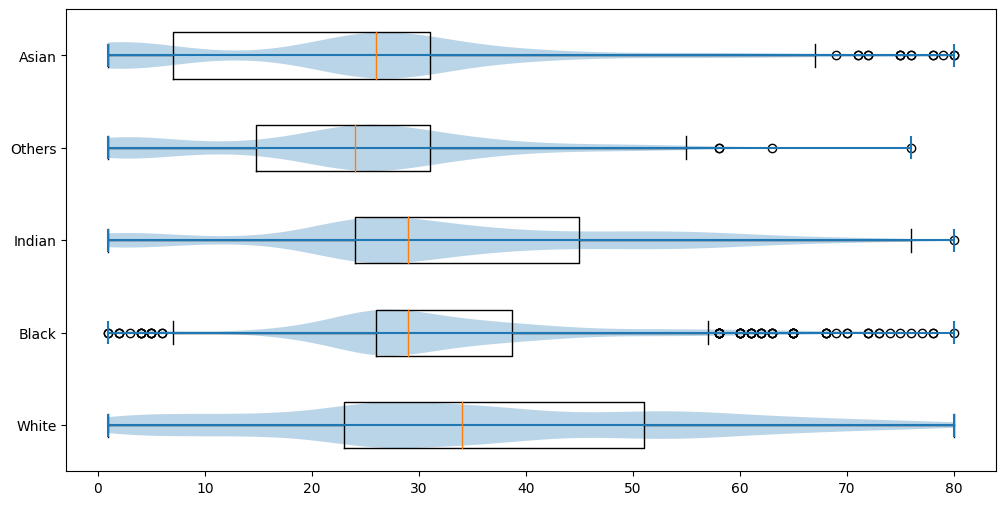

In [ ]:
plt.figure(figsize=(12, 6))
plt.boxplot([df.age[df.ethnicity == cat] for cat in df.ethnicity.unique()], vert=False, labels=df.ethnicity.unique())
plt.violinplot([df.age[df.ethnicity == cat] for cat in df.ethnicity.unique()], vert=False);

## 🟠 Split datasets

🔰 During this session, your task is to use scikit-learn's train_test_split function to partition the dataset into training, validation, and test sets.

In [ ]:
df_train, temp = train_test_split(df, test_size=0.3, stratify=df.age, random_state=42)
df_test, df_valid = train_test_split(temp, test_size=0.5, stratify=temp.age, random_state=42)

df_train.shape, df_test.shape, df_valid.shape

((16215, 4), (3475, 4), (3475, 4))

In [ ]:
df_train.head()

,image_name,age,ethnicity,gender
6601,58_0_3_20170119211538977.jpg.chip.jpg,58,Indian,Male
4473,24_0_1_20170113181434238.jpg.chip.jpg,24,Black,Male
16901,28_1_1_20170117022228379.jpg.chip.jpg,28,Black,Female
981,6_1_0_20170109202302115.jpg.chip.jpg,6,White,Female
15635,52_0_3_20170104220841902.jpg.chip.jpg,52,Indian,Male


###🟡 Plot histograms for age in the training, validation, and test sets.

⛔️ **Warning:** Ensure that the distributions of the training, validation, and test sets are similar.

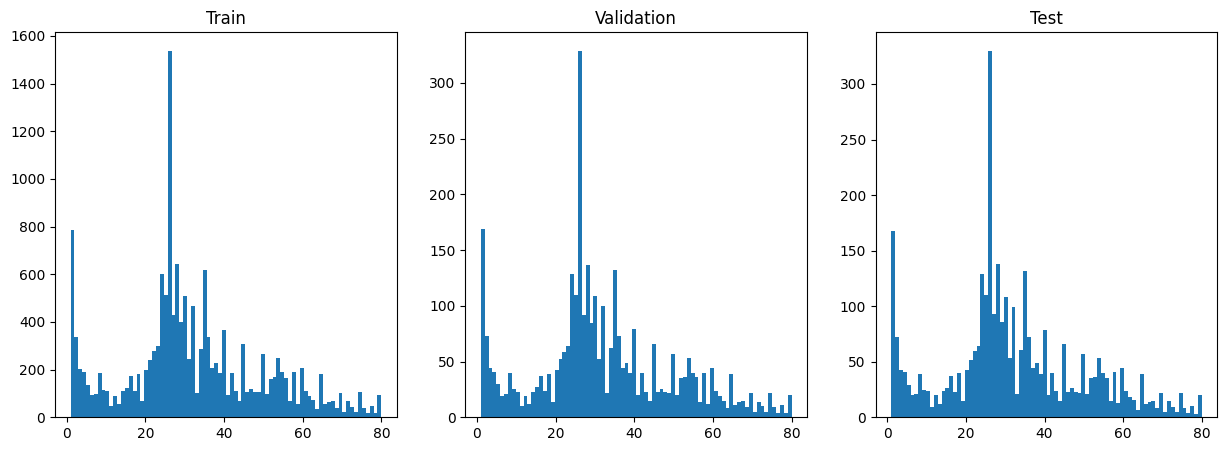

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

### 🟡 Save the training, validation, and test sets in separate CSV files.

In [ ]:
df_train.to_csv('/content/train_set.csv', index=False)
df_valid.to_csv('/content/valid_set.csv', index=False)
df_test.to_csv('/content/test_set.csv', index=False)

print('All CSV files created successfully.')

All CSV files created successfully.


##  Define transformations

🔰 During this session, your mission is to implement a data transformation pipeline using PyTorch's transforms.
The transformations should include:

*   Resizing images to a resolution of 128x128 pixels.
*   Applying random horizontal flips to the images.
*   Introducing random rotations of 15 degrees.
*   Adjusting image color using the ColorJitter transformation.
*   Converting the images to tensors.
*   Normalizing the pixel values using the provided mean and standard deviation values `(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

##  Custom dataset

🔰 Write a custom dataset class for UTKFace.

In [ ]:
class UTKDataset(Dataset):

    def __init__(self, root_dir, csv_file, transform=None):
      self.root_dir = root_dir
      self.csv_file = csv_file
      self.transform = transform
      self.data = pd.read_csv(csv_file)
      self.gender_dict = {'Male': 0, 'Female': 1}
      # self.ethnicity_dict = {}

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      sample = self.data.iloc[idx, :]

      img_name = sample.image_name
      img = Image.open(os.path.join(self.root_dir, img_name))

      age = torch.tensor([sample.age], dtype=torch.float32)
      gender = torch.tensor(self.gender_dict[sample.gender], dtype=torch.int32)
      ethnicity = sample.ethnicity

      img = self.transform(img)

      return img, age#, gender, ethnicity

In [ ]:
temp_dataset = UTKDataset(root_dir='/content/UTKFace',
                          csv_file='/content/valid_set.csv',
                          transform=test_transform)

temp_dataset.data, len(temp_dataset)
temp_dataset[10][1]

tensor([20.])

🔰 Utilize the UTKFace dataset class you've created to instantiate dataset objects for the training, validation, and test sets.

In [ ]:
dataset_dir = '/content/UTKFace'  # Dataset directory path

train_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/train_set.csv', transform=train_transform)
valid_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/valid_set.csv', transform=test_transform)
test_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/test_set.csv', transform=test_transform)

🔰 Plot a few images to verify the functionality of the dataset objects.

In [ ]:
idx = torch.randint(len(train_set), (1,))
img, age = train_set[idx.item()]
print(age.item())
img

31.0


tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

## 🟠 Define dataloader

🔰 Write dataloaders for the training, validation, and test sets.

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=256, shuffle=False)

🔰 Test the dataloaders using `next(iter())`

In [ ]:
train_iter = iter(train_loader)
train_iter

In [ ]:
imgs, ages = next(train_iter)
imgs.shape, ages.shape

(torch.Size([128, 3, 128, 128]), torch.Size([128, 1]))

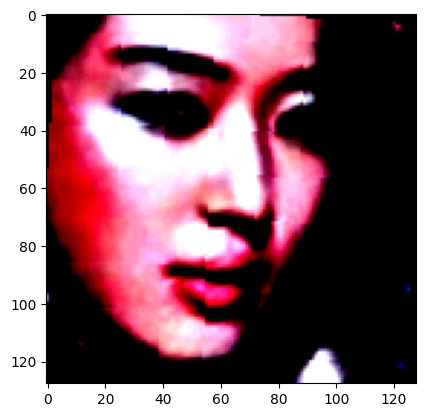

In [ ]:
plt.imshow(imgs[10].permute(1, 2, 0))

# 🔴 **Model**

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model(imgs).shape

torch.Size([128, 1])

🔰 Use the following template to create a custom model employing the ResNet-50 architecture

In [ ]:
class AgeEstimationModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    self.model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

  def forward(self, x):
    y = self.model(x)
    return y

🔰 Create an object for model using the AgeEstimationModel class you've created.

In [ ]:
model = AgeEstimationModel()
model(imgs).shape

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 269MB/s]


torch.Size([128, 1])

# 🔴 **Config**

🔰 Define the optimizer, loss function, and metrics in this section, and ensure the model is sent to the appropriate device.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = model.to(device)

In [ ]:
loss_fn = nn.L1Loss()
loss_fn

L1Loss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.02
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)

In [ ]:
metric = tm.MeanAbsoluteError().to(device)
metric

MeanAbsoluteError()

In [ ]:
metric.update(torch.tensor(6.), torch.tensor(4.))

In [ ]:
metric.compute()

tensor(2., device='cuda:0')

# 🔴 **Train ➰**

In [ ]:
epochs = 1

for epoch in range(epochs):
  for inputs, targets, _, _ in train_loader:
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  print(loss)

🔰Write the train function.

In [ ]:
with tqdm.tqdm(range(1000000)) as aa:
  for a in aa:
    b = np.exp(a/1000000)

100%|██████████| 1000000/1000000 [00:01<00:00, 708416.04it/s]


In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

In [ ]:
train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=1)

# 🔴 **Evaluation ➰**

In [ ]:
model.eval()
with torch.inference_mode():
  for inputs, targets in test_loader:
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    metric(outputs, targets)

🔰Write the evaluation function.

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

In [ ]:
evaluate(model, valid_loader, loss_fn, metric)

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model = AgeEstimationModel().to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)

print(loss)

tensor(31.7241, device='cuda:0')


In [ ]:
torch.cuda.empty_cache()

temp = torch.tensor(1, device=device)
model = temp.clone()
optimizer = temp.clone()
inputs = temp.clone()
targets = temp.clone()
outputs = temp.clone()

### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
model = AgeEstimationModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

Epoch 9: 100%|██████████| 50/50 [00:08<00:00,  6.04batch/s, loss=3.9, metric=3.9]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 3

for lr in [0.1, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')

  model = AgeEstimationModel().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR=0.1


Epoch 2: 100%|██████████| 127/127 [02:02<00:00,  1.03batch/s, loss=8.84, metric=8.84]



LR=0.01


Epoch 2: 100%|██████████| 127/127 [02:02<00:00,  1.04batch/s, loss=6.37, metric=6.37]



LR=0.001


Epoch 2: 100%|██████████| 127/127 [02:09<00:00,  1.02s/batch, loss=6.03, metric=6.03]



LR=0.0001


Epoch 2:   6%|▌         | 7/127 [00:06<01:53,  1.05batch/s, loss=17.9, metric=17.9]


KeyboardInterrupt: ignored

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs = 5

for lr in [0.005, 0.003, 0.001, 0.0007, 0.0005]:
  for wd in [1e-4, 1e-5, 0.]:
    print(f'LR={lr}, WD={wd}')

    model = AgeEstimationModel().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

    print()

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model = AgeEstimationModel().to(device)

In [ ]:
lr = 0.001
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, MAE = {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 127/127 [02:02<00:00,  1.03batch/s, loss=4.07, metric=4.07]


Valid: Loss = 4.837, MAE = 4.82



Epoch 1: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=3.96, metric=3.96]


Valid: Loss = 4.832, MAE = 4.81



Epoch 2: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=3.83, metric=3.83]


Model Saved!
Valid: Loss = 4.795, MAE = 4.772



Epoch 3: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=3.75, metric=3.75]


Valid: Loss = 4.854, MAE = 4.847



Epoch 4: 100%|██████████| 127/127 [02:02<00:00,  1.03batch/s, loss=3.65, metric=3.65]


Model Saved!
Valid: Loss = 4.757, MAE = 4.733



Epoch 5: 100%|██████████| 127/127 [02:02<00:00,  1.04batch/s, loss=3.57, metric=3.57]


Model Saved!
Valid: Loss = 4.744, MAE = 4.723



Epoch 6: 100%|██████████| 127/127 [02:02<00:00,  1.04batch/s, loss=3.51, metric=3.51]


Valid: Loss = 4.974, MAE = 4.952



Epoch 7: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=3.43, metric=3.43]


Valid: Loss = 4.858, MAE = 4.83



Epoch 8: 100%|██████████| 127/127 [02:01<00:00,  1.04batch/s, loss=3.31, metric=3.31]


Model Saved!
Valid: Loss = 4.721, MAE = 4.705



Epoch 9: 100%|██████████| 127/127 [02:03<00:00,  1.03batch/s, loss=3.29, metric=3.29]


Valid: Loss = 4.781, MAE = 4.754



## 🟠 Main Loop

🔰 Define model.

In [ ]:
model = AgeEstimationModel().to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
lr = 0.001
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, MAE = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Plot

🔰 Plot learning curves

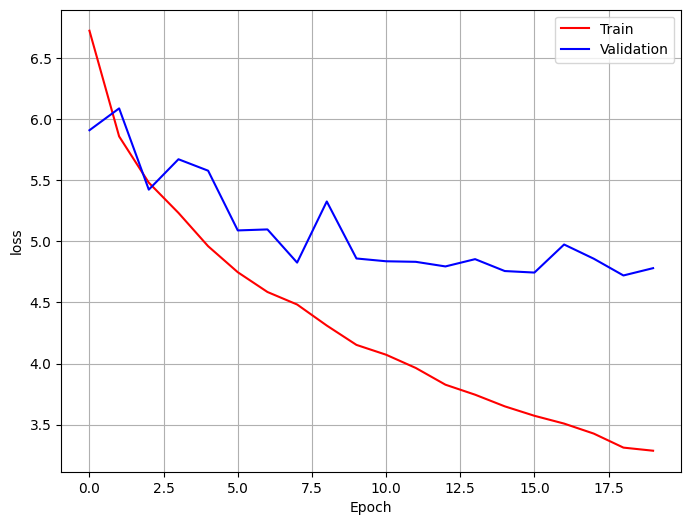

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

In [ ]:
!cp /content/drive/MyDrive/deep-catalyst/project_0-age_estimation/model.pt /content/

In [ ]:
model_path = '/content/model.pt'
model = torch.load(model_path)
model.eval()

🔰 Test your model using data from the test set and images that are not present in the dataset.

In [ ]:
_, metric_train = evaluate(model, train_loader, loss_fn, metric)
_, metric_valid = evaluate(model, valid_loader, loss_fn, metric)
_, metric_test = evaluate(model, test_loader, loss_fn, metric)

metric_train, metric_valid, metric_test

(3.9679298400878906, 3.6602721214294434, 3.8583877086639404)

# 🔴 **Inference**

In [ ]:
!cp /content/drive/MyDrive/deep-catalyst/project_0-age_estimation/model.pt /content/

In [ ]:
model_path = '/content/model.pt'
model = torch.load(model_path)
model.eval()

🔰 your mission is to:

*   Write an inference function.
*   load an image from outside the UTKFace dataset
*   and evaluate the model's prediction.

In [ ]:
!pip install face-recognition

In [ ]:
import face_recognition

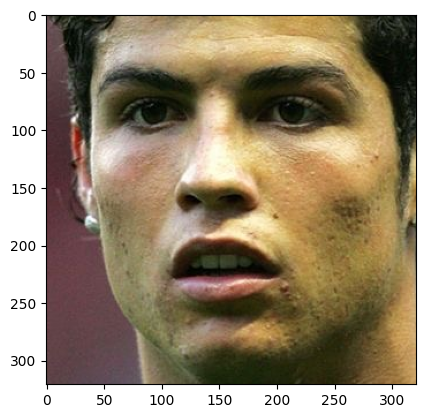

In [ ]:
img = face_recognition.load_image_file('/content/ronaldo.jpg')
top, right, bottom, left = face_recognition.face_locations(img)[0]
img_crop = img[top:bottom, left:right]
plt.imshow(img_crop);

In [ ]:
img_crop = Image.fromarray(img_crop)
img_tensor = test_transform(img_crop).unsqueeze(0)
img_tensor.shape

torch.Size([1, 3, 128, 128])

In [ ]:
with torch.inference_mode():
  preds = model(img_tensor.to(device)).item()
preds

28.3347110748291

In [ ]:
def inference(image_path, transform, model, face_detection=False):
  if face_detection:
    img = face_recognition.load_image_file(image_path)
    top, right, bottom, left = face_recognition.face_locations(img)[0]
    img_crop = img[top:bottom, left:right]
    img_crop = Image.fromarray(img_crop)
  else:
    img_crop = Image.open(image_path).convert('RGB')

  img_tensor = transform(img_crop).unsqueeze(0)
  with torch.inference_mode():
    preds = model(img_tensor.to(device)).item()

  return preds, img_crop

28.33


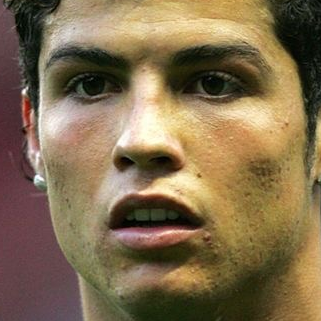

In [ ]:
preds, img = inference('/content/ronaldo.jpg',
          test_transform, model, face_detection=True)

print(f'{preds:.2f}')
img

Real: 32, Predicted: 36.51


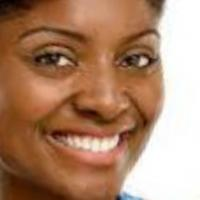

In [ ]:
# Load a random image from a folder
folder_image_path = '/content/UTKFace/'
image_files = os.listdir(folder_image_path)

rand_idx = random.randint(0, len(image_files))
test_image_path = os.path.join(folder_image_path, image_files[rand_idx])
predicted_age, image = inference(test_image_path, test_transform, model)

real_age = image_files[rand_idx].split('_')[0]
print(f"Real: {real_age}, Predicted: {predicted_age:.2f}")
image

Real: 27, Predicted: 27.44


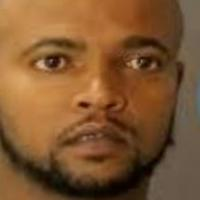

In [ ]:
# Load a random image from a casv file
csv_file_path = '/content/test_set.csv'
df = pd.read_csv(csv_file_path)

rand_idx = random.randint(0, df.shape[0])
test_image_name = df.iloc[rand_idx].image_name
test_image_path = os.path.join(folder_image_path, test_image_name)
predicted_age, image = inference(test_image_path, test_transform, model)

real_age = test_image_name.split('_')[0]
print(f"Real: {real_age}, Predicted: {predicted_age:.2f}")
image

# 🔴 **Experiments**

In [ ]:
!cp /content/drive/MyDrive/deep-catalyst/project_0-age_estimation/model.pt /content/

In [ ]:
model_path = '/content/model.pt'
model = torch.load(model_path)
model.eval()

## 🟠 Train and evaluate the model using various datasets.

## 🟠 Train the model using one dataset and then test it on a different one.

## 🟠 Analyze the MAE value with respect to age, gender and race.

In [ ]:
all_outputs, all_targets = [], []

for inputs, targets in test_loader:
  inputs = inputs.to(device)
  targets = targets.to(device)

  with torch.inference_mode():
    outputs = model(inputs)

  all_outputs.append(outputs)
  all_targets.append(targets)

In [ ]:
all_outputs = torch.vstack(all_outputs).squeeze()
all_targets = torch.vstack(all_targets).squeeze()
all_outputs.shape, all_targets.shape

(torch.Size([3475]), torch.Size([3475]))

In [ ]:
mae = F.l1_loss(all_outputs, all_targets, reduction='none')
mae.shape

torch.Size([3475])

In [ ]:
df_test = pd.read_csv('/content/test_set.csv')

df_test['preds'] = all_outputs.cpu()
df_test['maes'] = mae.cpu()
df_test.to_csv('/content/test_outputs.csv')
df_test.head()

,image_name,age,ethnicity,gender,preds,maes
0,56_0_0_20170111211219557.jpg.chip.jpg,56,White,Male,62.469162,6.469162
1,48_1_1_20170113001756978.jpg.chip.jpg,48,Black,Female,45.094574,2.905426
2,34_0_3_20170119163319768.jpg.chip.jpg,34,Indian,Male,26.050079,7.949921
3,46_0_0_20170117172149820.jpg.chip.jpg,46,White,Male,51.015930,5.015930
4,4_1_0_20170109192831145.jpg.chip.jpg,4,White,Female,4.803345,0.803345


In [ ]:
df_test.groupby('age')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
1,168.0,0.389224,1.923051,0.001850,0.052314,0.125476,0.257917,24.665125
2,72.0,0.914027,2.915755,0.043929,0.302487,0.607371,0.844322,25.176619
3,43.0,1.272669,1.094575,0.039776,0.603820,1.244751,1.497289,5.921664
4,41.0,1.289426,0.883808,0.096410,0.762811,1.032654,1.652438,3.619977
5,29.0,4.087986,11.722061,0.003478,0.652091,1.531191,2.427211,63.846085
...,...,...,...,...,...,...,...,...
76,8.0,8.892060,7.021187,1.053177,3.113369,9.274540,11.383196,22.718590
77,4.0,17.300947,21.480959,1.489090,6.167801,9.370941,20.504087,48.972816
78,10.0,5.740116,3.690342,0.846886,2.524683,6.559471,8.118177,10.914688


<BarContainer object of 80 artists>

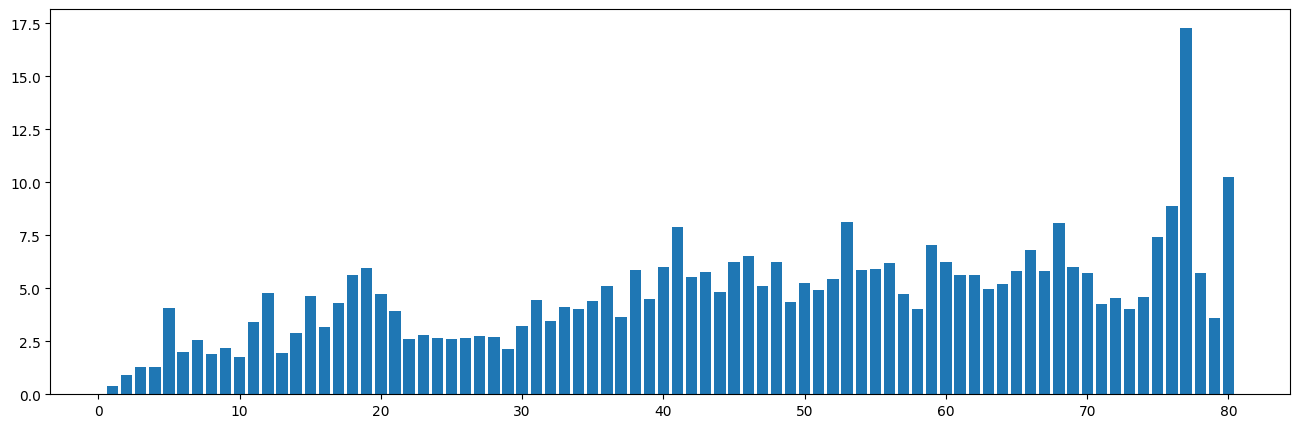

In [ ]:
plt.figure(figsize=(16, 5))
plt.bar(df_test.groupby('age')['maes'].describe().index,
        df_test.groupby('age')['maes'].describe()['mean'])

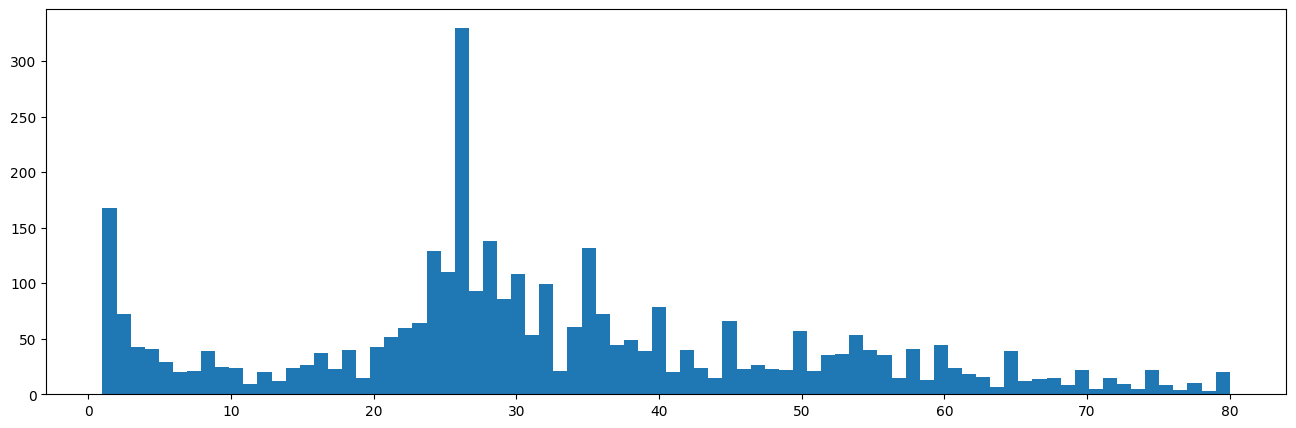

In [ ]:
plt.figure(figsize=(16, 5))
plt.hist(df_test.age, bins=len(df_test.age.unique()));

In [ ]:
df_test.groupby('gender')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,1642.0,3.638013,4.071262,0.003473,0.877436,2.247769,5.146206,35.854446
Male,1833.0,4.055799,4.588873,0.001850,1.011410,2.653451,5.567177,63.846085


In [ ]:
df_test.groupby('ethnicity')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
ethnicity,,,,,,,,
Asian,481.0,2.678043,3.435051,0.003478,0.451847,1.517508,3.579519,28.960670
Black,682.0,4.165312,4.912383,0.009321,1.186602,2.728031,5.519853,63.846085
Indian,599.0,3.802157,4.099485,0.003111,0.925159,2.293163,5.360360,28.494675
Others,264.0,3.005197,3.734072,0.001850,0.651750,1.533026,4.287949,25.814035
White,1449.0,4.284438,4.469285,0.008339,1.174294,2.798244,6.025372,36.115005


In [ ]:
ranges = np.arange(df.age.min()-1, df.age.max()+1, 5)
df_test['age_period'] = pd.cut(df.age, bins=ranges)
df_test.head()

,image_name,age,ethnicity,gender,preds,maes,age_period
0,56_0_0_20170111211219557.jpg.chip.jpg,56,White,Male,62.469162,6.469162,"(55, 60]"
1,48_1_1_20170113001756978.jpg.chip.jpg,48,Black,Female,45.094574,2.905426,"(45, 50]"
2,34_0_3_20170119163319768.jpg.chip.jpg,34,Indian,Male,26.050079,7.949921,"(30, 35]"
3,46_0_0_20170117172149820.jpg.chip.jpg,46,White,Male,51.015930,5.015930,"(45, 50]"
4,4_1_0_20170109192831145.jpg.chip.jpg,4,White,Female,4.803345,0.803345,"(0, 5]"


<BarContainer object of 16 artists>

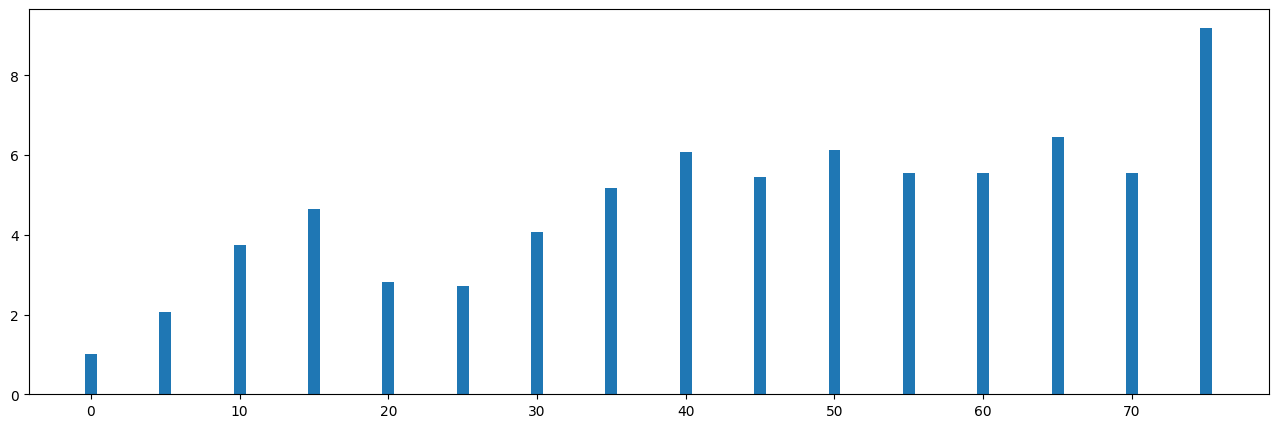

In [ ]:
plt.figure(figsize=(16, 5))
plt.bar(ranges[:-1],
        df_test.groupby('age_period')['maes'].describe()['mean']);

In [ ]:
df_test.groupby('age_period')['maes'].describe().index

CategoricalIndex([  (0, 5],  (5, 10], (10, 15], (15, 20], (20, 25], (25, 30],
                  (30, 35], (35, 40], (40, 45], (45, 50], (50, 55], (55, 60],
                  (60, 65], (65, 70], (70, 75], (75, 80]],
                 categories=[(0, 5], (5, 10], (10, 15], (15, 20], ..., (60, 65], (65, 70], (70, 75], (75, 80]], ordered=True, dtype='category', name='age_period')

In [ ]:
df_test.groupby('age_period')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
age_period,,,,,,,,
"(0, 5]",353.0,1.012302,3.951579,0.001850,0.108633,0.324937,0.939247,63.846085
"(5, 10]",129.0,2.065547,2.221923,0.008767,0.591191,1.485270,2.686879,15.923677
"(10, 15]",91.0,3.736832,3.847648,0.030261,1.209951,2.489079,4.582698,19.172451
"(15, 20]",158.0,4.642495,3.773522,0.146357,1.997196,4.191664,6.471102,35.451073
"(20, 25]",415.0,2.817732,2.882396,0.007601,0.852702,1.888273,3.758379,19.428413
"(25, 30]",755.0,2.704500,3.112689,0.003111,0.840248,1.791012,3.411015,36.115005
"(30, 35]",366.0,4.076678,3.162982,0.015032,1.754726,3.469629,5.769188,19.447178
"(35, 40]",283.0,5.177219,3.951563,0.008339,1.947889,4.455368,7.517690,20.117664
"(40, 45]",165.0,6.076422,4.826535,0.097233,2.590431,4.608017,9.079330,26.737850


## 🟠 Analyze the model's sensitivity.

9.09


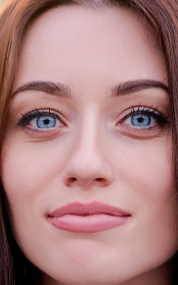

In [ ]:
test_image_path = '/content/2.png'
img = Image.open(test_image_path).convert('RGB')

img_tensor = test_transform(img).unsqueeze(0)

with torch.inference_mode():
  predicted_age = model(img_tensor.to(device)).item()

print(f'{predicted_age:.2f}')
img

## 🟠 Create a heatmap for the face images.